# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [1]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
from glob import glob
# import glob
import numpy as np
import importlib
import multiprocessing
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
from F_utils import *
from F_fwi import *
import pyapi_denise_pavel as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')
# create_sbatch_file_for_fwi_folder('./for_pasha/out_for_pasha/fwi_full_spectrum_vanilla')
# results_path='./out_for_pasha/fwi_full_spectrum'
# os.system(f"rm -r {results_path}")
print(filter_seismic_data)
d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=1)
print(d.get_shots_from_datadir)
print(d.get_shots_from_directory)
print(sys.path)

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
<function filter_seismic_data at 0x7f5c3c0111e0>
Init Python 3 API for Denise-Black-Edition.
Check binary in /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/bin/denise
Parse /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
<bound method Denise.get_shots_from_datadir of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
<bound method Denise.get_shots_from_directory of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-

In [2]:
calculate_water_taper

<function F_utils.calculate_water_taper(generated_model, min_water_velocity=1490.001)>

In [3]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 300,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [5]:
root_fwi = './out_for_pasha/'

# Init Denise API

In [6]:
denise_root = '../'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/


## Work directory
Where to output everything

In [7]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/


# Get acquitision details

In [8]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

In [ ]:
%run ./fwi_shared_check.ipynb

In [10]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))

Field data spacing between sources 149.75 m


In [11]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')

def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho

(152, 600)
./out_for_pasha/start/


Extend the model so it accommodates full streamer length for the last shot

(152, 600)
(152, 600)
(152, 944)
(152, 944)
(152, 500)
(152, 944)


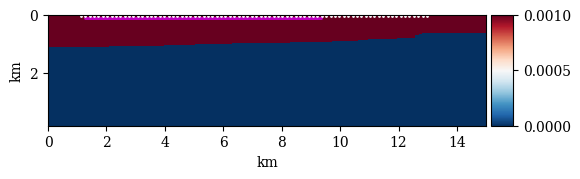

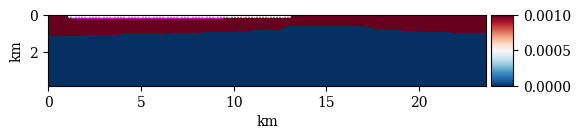

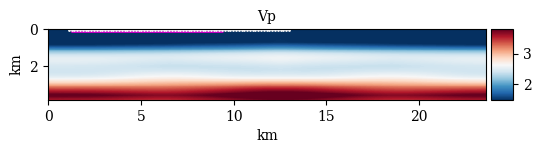

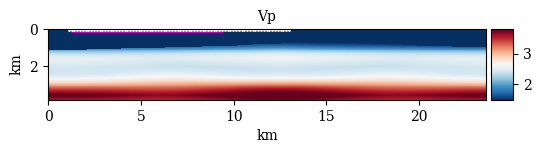

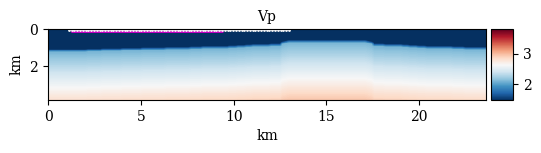

In [12]:
vp_long = extend(model.vp, 0, 264 + 10 * 8)
vp_cgg_tomo=vp_cgg
vp_cgg_tomo_long = extend(vp_cgg_tomo, 0, 364 + 10 * 8)
wb_taper2=extend(wb_taper, 0,264 + 10 * 8)
vp_cgg_tomo_long2=np.where(wb_taper2,1490.0,vp_cgg_tomo_long)
lin_vp_long=vp_long.copy()
# print(src)
# # print(rec)
# print(vp_baseline.shape)
print(model.vp.shape)
print(wb_taper.shape)
print(wb_taper2.shape)
print(vp_long.shape)
print(vp_cgg_tomo.shape)
print(vp_cgg_tomo_long.shape)
# vis.plot_acquisition(vp_baseline,dx,src,rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(model.vp,dx,src,rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(vp_cgg_tomo, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_acquisition(wb_taper,dx,src,rec)
vis.plot_acquisition(wb_taper2,dx,src,rec)
vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_acquisition(vp_cgg_tomo_long2, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_acquisition(lin_vp_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})

## Acquisition design

In [13]:
# Wavelet scaler to match field and synthetic
wavefield_amp_ratio = 77.08343437940496

In [14]:
print(1.01 * vp_cgg_tomo_long.min())
print(1.0 * vp_cgg_tomo_long.min())

1504.9
1490.0


(152, 600)
(152, 944)


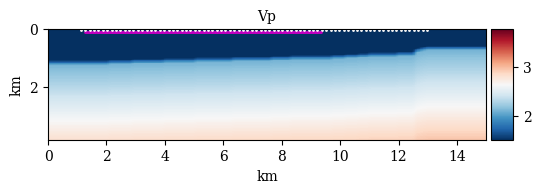

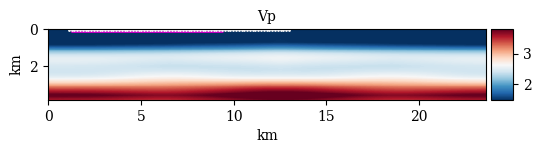

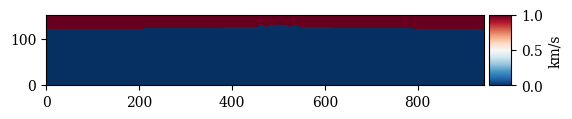

In [15]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wavefield_amp_ratio * wls[:, :limit_nt]
wb_taper = np.where(vp_cgg_tomo_long < 1.01 * vp_cgg_tomo_long.min(), 1, 0)
wb_taper3=calculate_water_taper(np.flipud(vp_cgg_tomo_long),min_water_velocity=1.01 * vp_cgg_tomo_long.min())
wb_taper3=np.flipud(wb_taper3)
# vis.plot_model(wb_taper3-wb_taper)
wb_taper=wb_taper3
vis.plot_acquisition(vp,dx,src,rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_model(wb_taper3)
# print(vp_cgg_tomo_long)
print(vp.shape)
print(vp_cgg_tomo_long.shape)

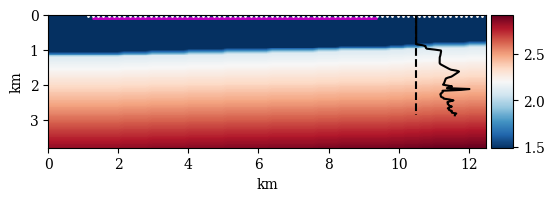

In [16]:
# log = model.vp[:, log_idx]
log = model.vp[-len(wlog):, log_idx]
# model_log = copy.deepcopy(model)
log_dict = {'data':wlog, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
# vis.savefig('vinit.png')

Create new initial (orange line). This is to see whether knowledge about exact waterbottom will improve results

In [17]:
new_vp = np.zeros_like(model.vp)
vps=[]
for i in range(wb_taper.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i]) + 2
    fun = vmin * np.ones_like(new_vp[:, 0:1])
    fun[wb:, :] = 690 + fun[wb:, :] + 6 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
    vps.append(fun)
new_vp = np.concatenate(vps, -1)
new_vp = gaussian_filter(new_vp.copy(), **sigma_truncate)

print(new_vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
# plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(new_vp[-len(wlog):, log_idx])

(152, 944)
Well-log from 10500 maps into ix: 420


Set new model as initial

In [18]:
vp = vp_cgg_tomo_long.copy()
# vp = new_vp.copy()
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

vp = np.where(wb_taper, np.min(vp_cgg), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# log = vplog.copy()
model = api.Model(vp, vs, rho, dx)
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [19]:
acq_data = {'src':src,'rec':rec,'wavelet':bpw,'src_x0':src_x0,'rec_x0':rec_x0,'dsrc':dsrc,'drec':drec,'dDT':dDT}
print(os.getcwd())
with open(os.path.join('acq_data_parameters.pkl'),'rb') as input:
    d2=pickle.load(input)
# print(d2)
print(src)
print(d2['src'])
# with open(os.path.join('for_pasha','acq_data_parameters.pkl'), 'wb+') as output:
#     pickle.dump(acq_data,output,protocol=4)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
name:	
x	(60,):	min: 1125.0	max: 9975.0
y	(60,):	min: 50.0	max: 50.0
wavelets:	None
z	(60,):	min: 0.0	max: 0.0
nshot:	60
td	(60,):	min: 0.0	max: 0.0
fc	(60,):	min: 8.0	max: 8.0
amp	(60,):	min: 1.0	max: 1.0
angle	(60,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(60,):	min: 1.0	max: 1.0


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [20]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
# DSCRC=5000;     
# dsrc=DSCRC
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)
d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10
d.QUELLTYPB = 4
d.QUELLART = 3  
d.WRITE_STF = 0
d.SEISMO = 2

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5
print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [21]:
d.NPROCX = 1
d.NPROCY = 1
par_forward = {'run_command': 'mpirun -np 30', 'disable': True}

In [22]:
d.forward(model, src, rec, **par_forward)
# d.save_folder = root_fwi

Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 865.6191019897758 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.383404899618165 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_for_pasha/start/model.vp
Write ./out_for_pasha/start/model.vs
Write ./out_for_pasha/start/model.rho
Enable streamer mode!
	source 1: ./out_for_pasha/receiver/receivers_shot_1
	source 2: ./out_for_pasha/receiver/receivers_shot_2
	source 3: ./out_for_pasha/receiver/receivers_shot_3
	source 4: ./out_for_pasha/receiver/receivers_shot_4
	source 5: ./out_for_pasha/receiver/receivers_shot_5
	source 6: ./out_for_pasha/receiver/receivers_shot_6
	source 7: ./out_for_pasha/receiver/receivers_shot_7
	source 8: ./out_for_pasha/receiver/receivers_shot_8
	source 9: ./out_for_pasha/receiver/receivers_shot_9
	source 10: ./out_for_pasha/recei

In [56]:
d.verbose = 0    # don't show redundant print outs
if d.DT is None:
    d.DT = 0.002
print(d.DATA_DIR)
shots = d.get_shots(keys=['_p.'])
mpl.rcParams['figure.dpi']= 300
par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
        try:
            shot_s = shots[i]
            shot_f = data_p[i, :, ::d.NDT]
#             vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
        except:
            print(f'Failed to fetch data for i={i}')

./out_for_pasha/fwi_full_spectrum/fld/su/seis
Read 80 shots (324, 3000) into list


In [24]:
# wavefield_amp_ratio
print(np.max(np.abs(shot_f)) / np.max(np.abs(shot_s)) )

1.0229216568038049


# Compare syn and field

(80, 324, 3000)
80
Total sources: 80
Syn wavelets:	(80, 500)	-13549.72	18647.84
Field wavelets:	(80, 500)	-16728.73	24865.97
[0, 8, 17, 26, 35, 43, 52, 61, 70, 79]


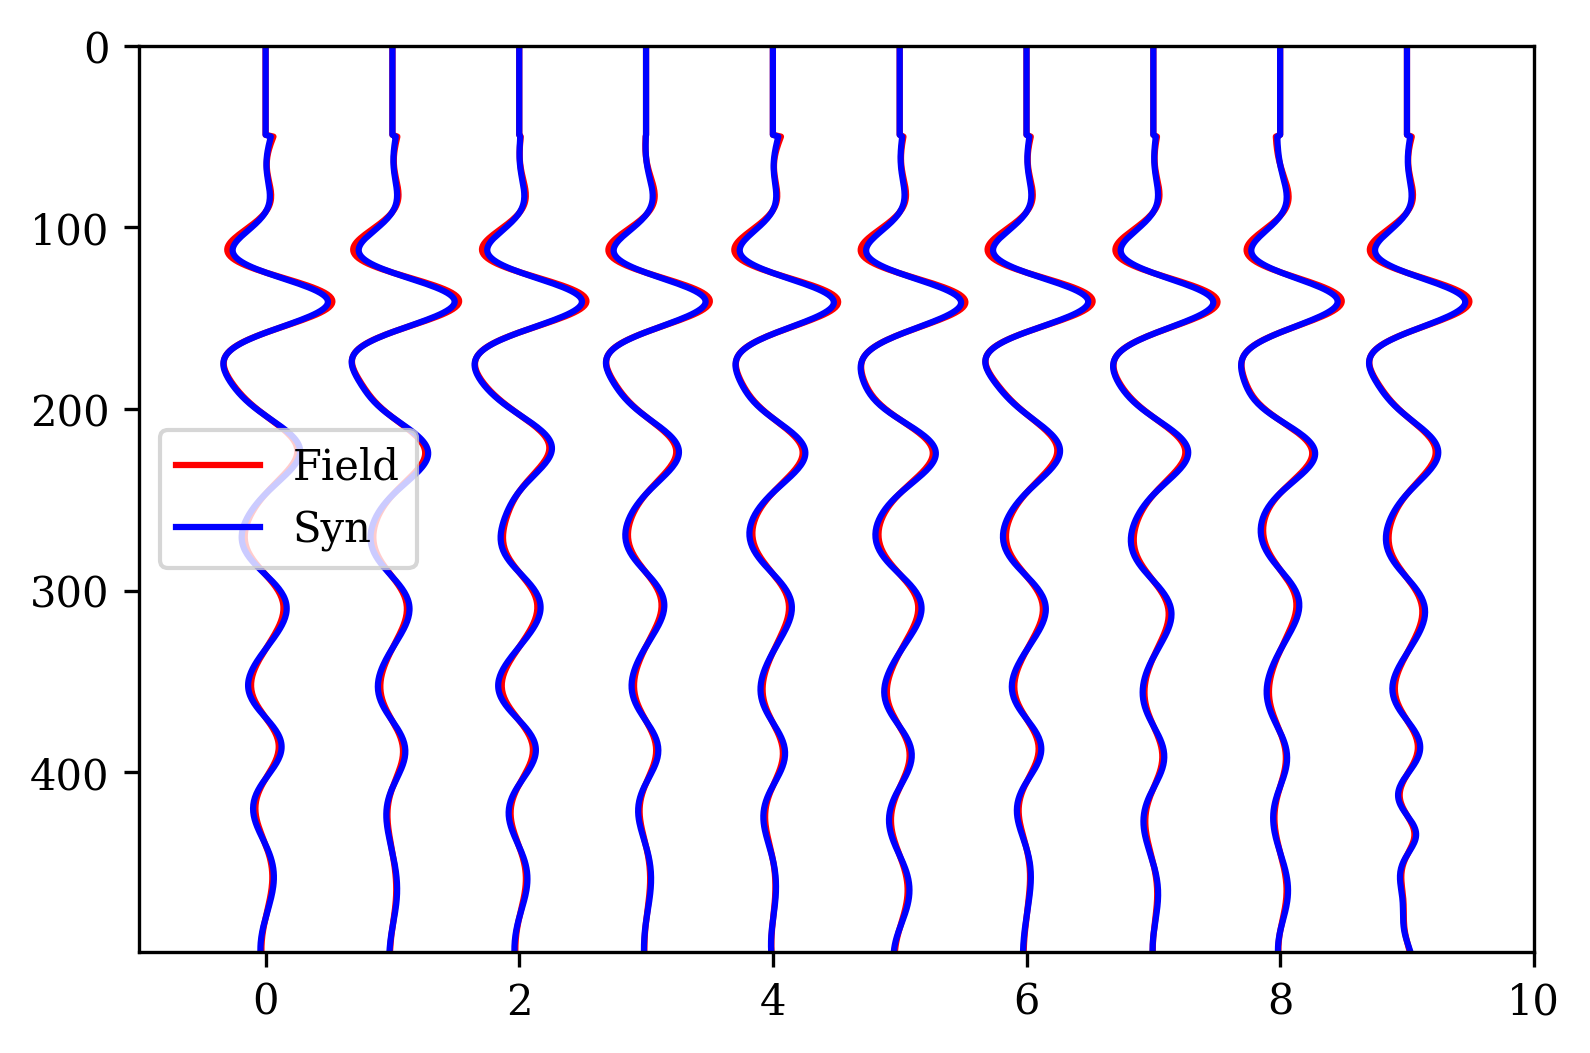

In [25]:
wavelets_s = []
wavelets_f = []
print(data_p.shape)
print(len(shots))
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
    wavelets_f.append(data_p[i, :no, :nt:d.NDT].copy())
print(f'Total sources: {len(wavelets_f)}')
wavelets_s = np.concatenate(wavelets_s, 0)
wavelets_f = np.concatenate(wavelets_f, 0)

# !!! DO THIS IN FIELD DATA APPLICATION !!!
# THIS MAKES SYNTHETIC AND FIELD COMPARABLE
# OTHERWISE THERE IS INSANE AMPLITUDE MISMATCH
# wavelets_f /= np.max(wavelets_f)
# wavelets_f *= wavelets_s.max()

print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
print('Field wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_f.shape, wavelets_f.min(), wavelets_f.max()))

vis.plot_wiggles([wavelets_f, wavelets_s], n=10, colors=['r', 'b'], legend=['Field', 'Syn'])

Save /home/plotnips/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/wavelet_syn_field.png


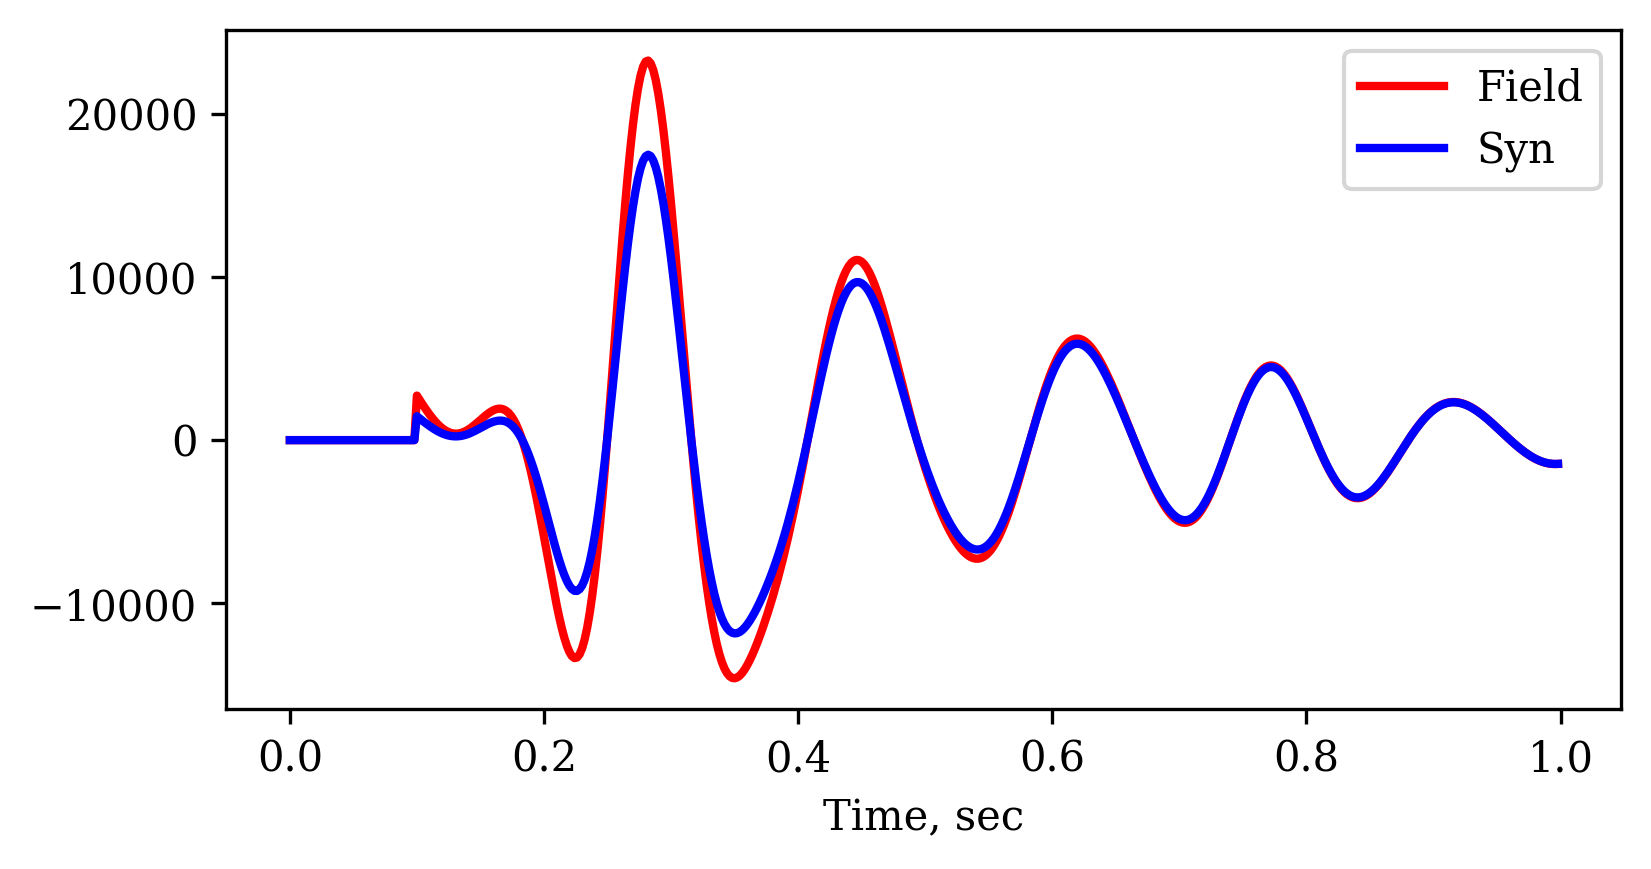

In [26]:
if shots:
    tvec = np.arange(nt) * d.DT
    plt.figure(figsize=(6,3)); 
    trace_idx = 0
    plt.plot(tvec, wavelets_f[trace_idx,:], 'r', lw=2, label='Field')
    plt.plot(tvec, wavelets_s[trace_idx,:], 'b', lw=2, label='Syn')
    # plt.plot(tvec, _dplotted[0][0], 'r', lw=2, label='Field')
    # plt.plot(tvec, _dplotted[1][0], 'b', lw=2, label='Syn')
    plt.legend()
    plt.xlabel('Time, sec')
    vis.savefig('wavelet_syn_field.png')

# REPLACE FIELD DATA BY MARM DATA

In [27]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
# print(data_p.shape)

In [28]:
par_mutter = {'k': 7, 'b': -100, 'r': 30}

new_data_p = []
for idat in range(data_p.shape[0]):
    new_data_p.append(np.expand_dims(ld.mutter(data_p[idat, ...], **par_mutter), 0))
new_data_p = np.concatenate(new_data_p)
data_p=new_data_p.copy()

In [29]:
new_data_p.shape

(80, 324, 3000)

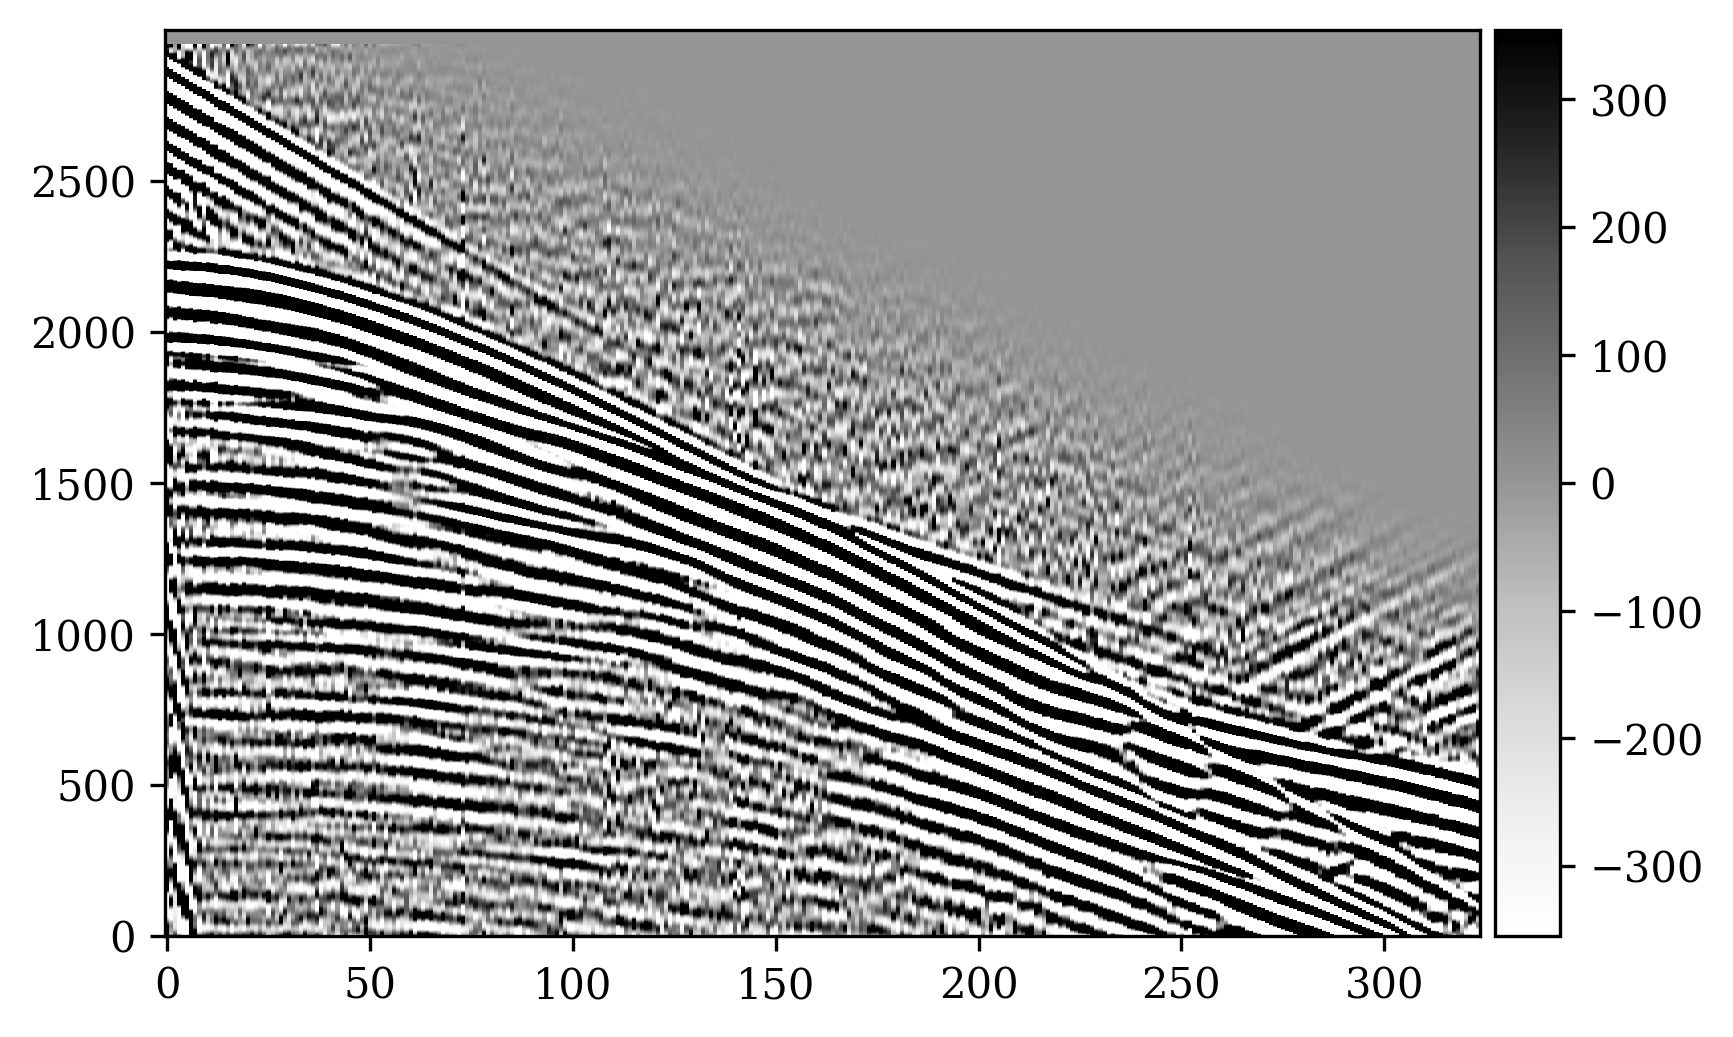

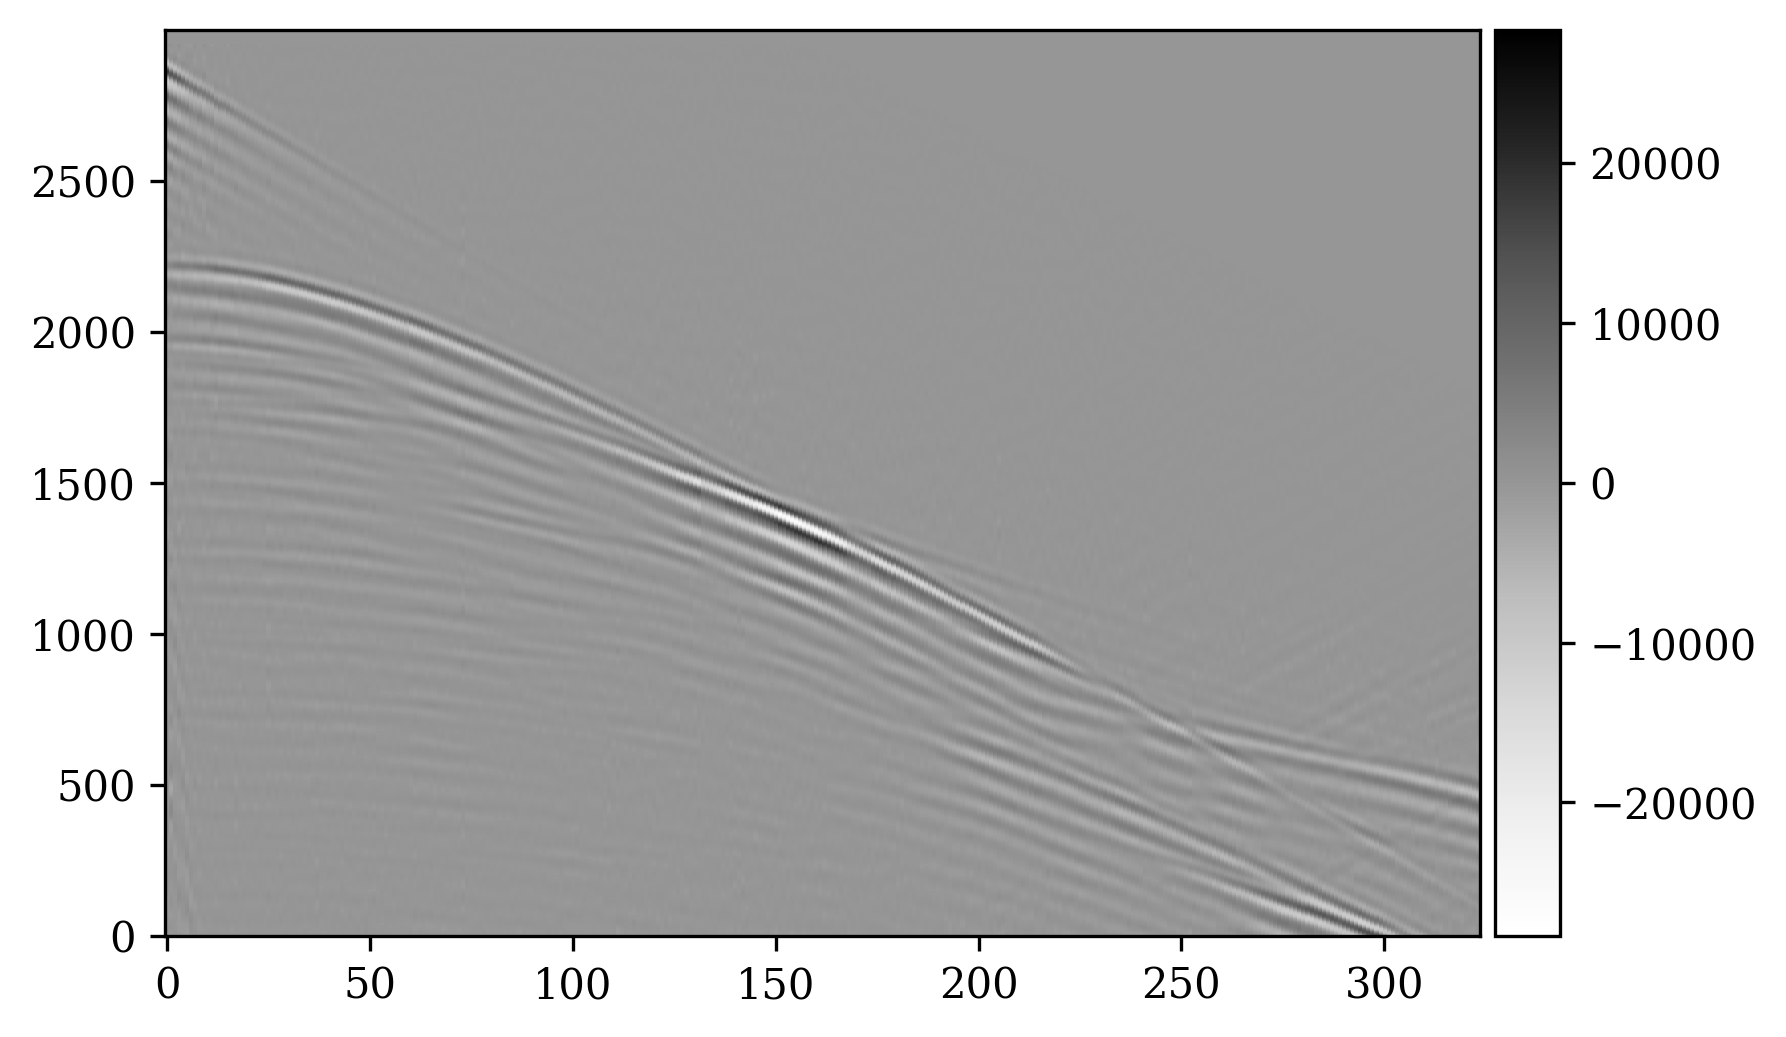

In [30]:
vis.plot_shot(new_data_p[0,...], pclip=0.0125)
vis.plot_shot(new_data_p[0,...])

In [31]:
# vis.plot_spectrum2(data_p[0,...], pclip=0.5, title='', colorbar=False, dt=0.002, dx=dx, fmax=20, kmax=None,
#                    figsize=None, axis=True, plot_only=False)

In [32]:
# par_mutter = {'k': 7, 'b': 100, 'r': 30}
# vis.plot_shot(ld.mutter(data_p[0,...], **par_mutter), pclip=0.0125)

In [33]:
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)

(80, 324, 3000) 0.002


Geometric spreading correction (not used)

In [34]:
geom = np.repeat(np.repeat(np.arange(1, data_p.shape[-1]+1)[np.newaxis, ...] * d.DT, data_p.shape[1], 0)[np.newaxis, ...], data_p.shape[0], 0) ** 0.5

# Overwrite by ones, so it is not used
geom = np.ones_like(geom)
data_p = data_p_backup * geom
# data_p = data_p_backup

(80, 324, 3000) -36656.91057431045 28939.26894342203


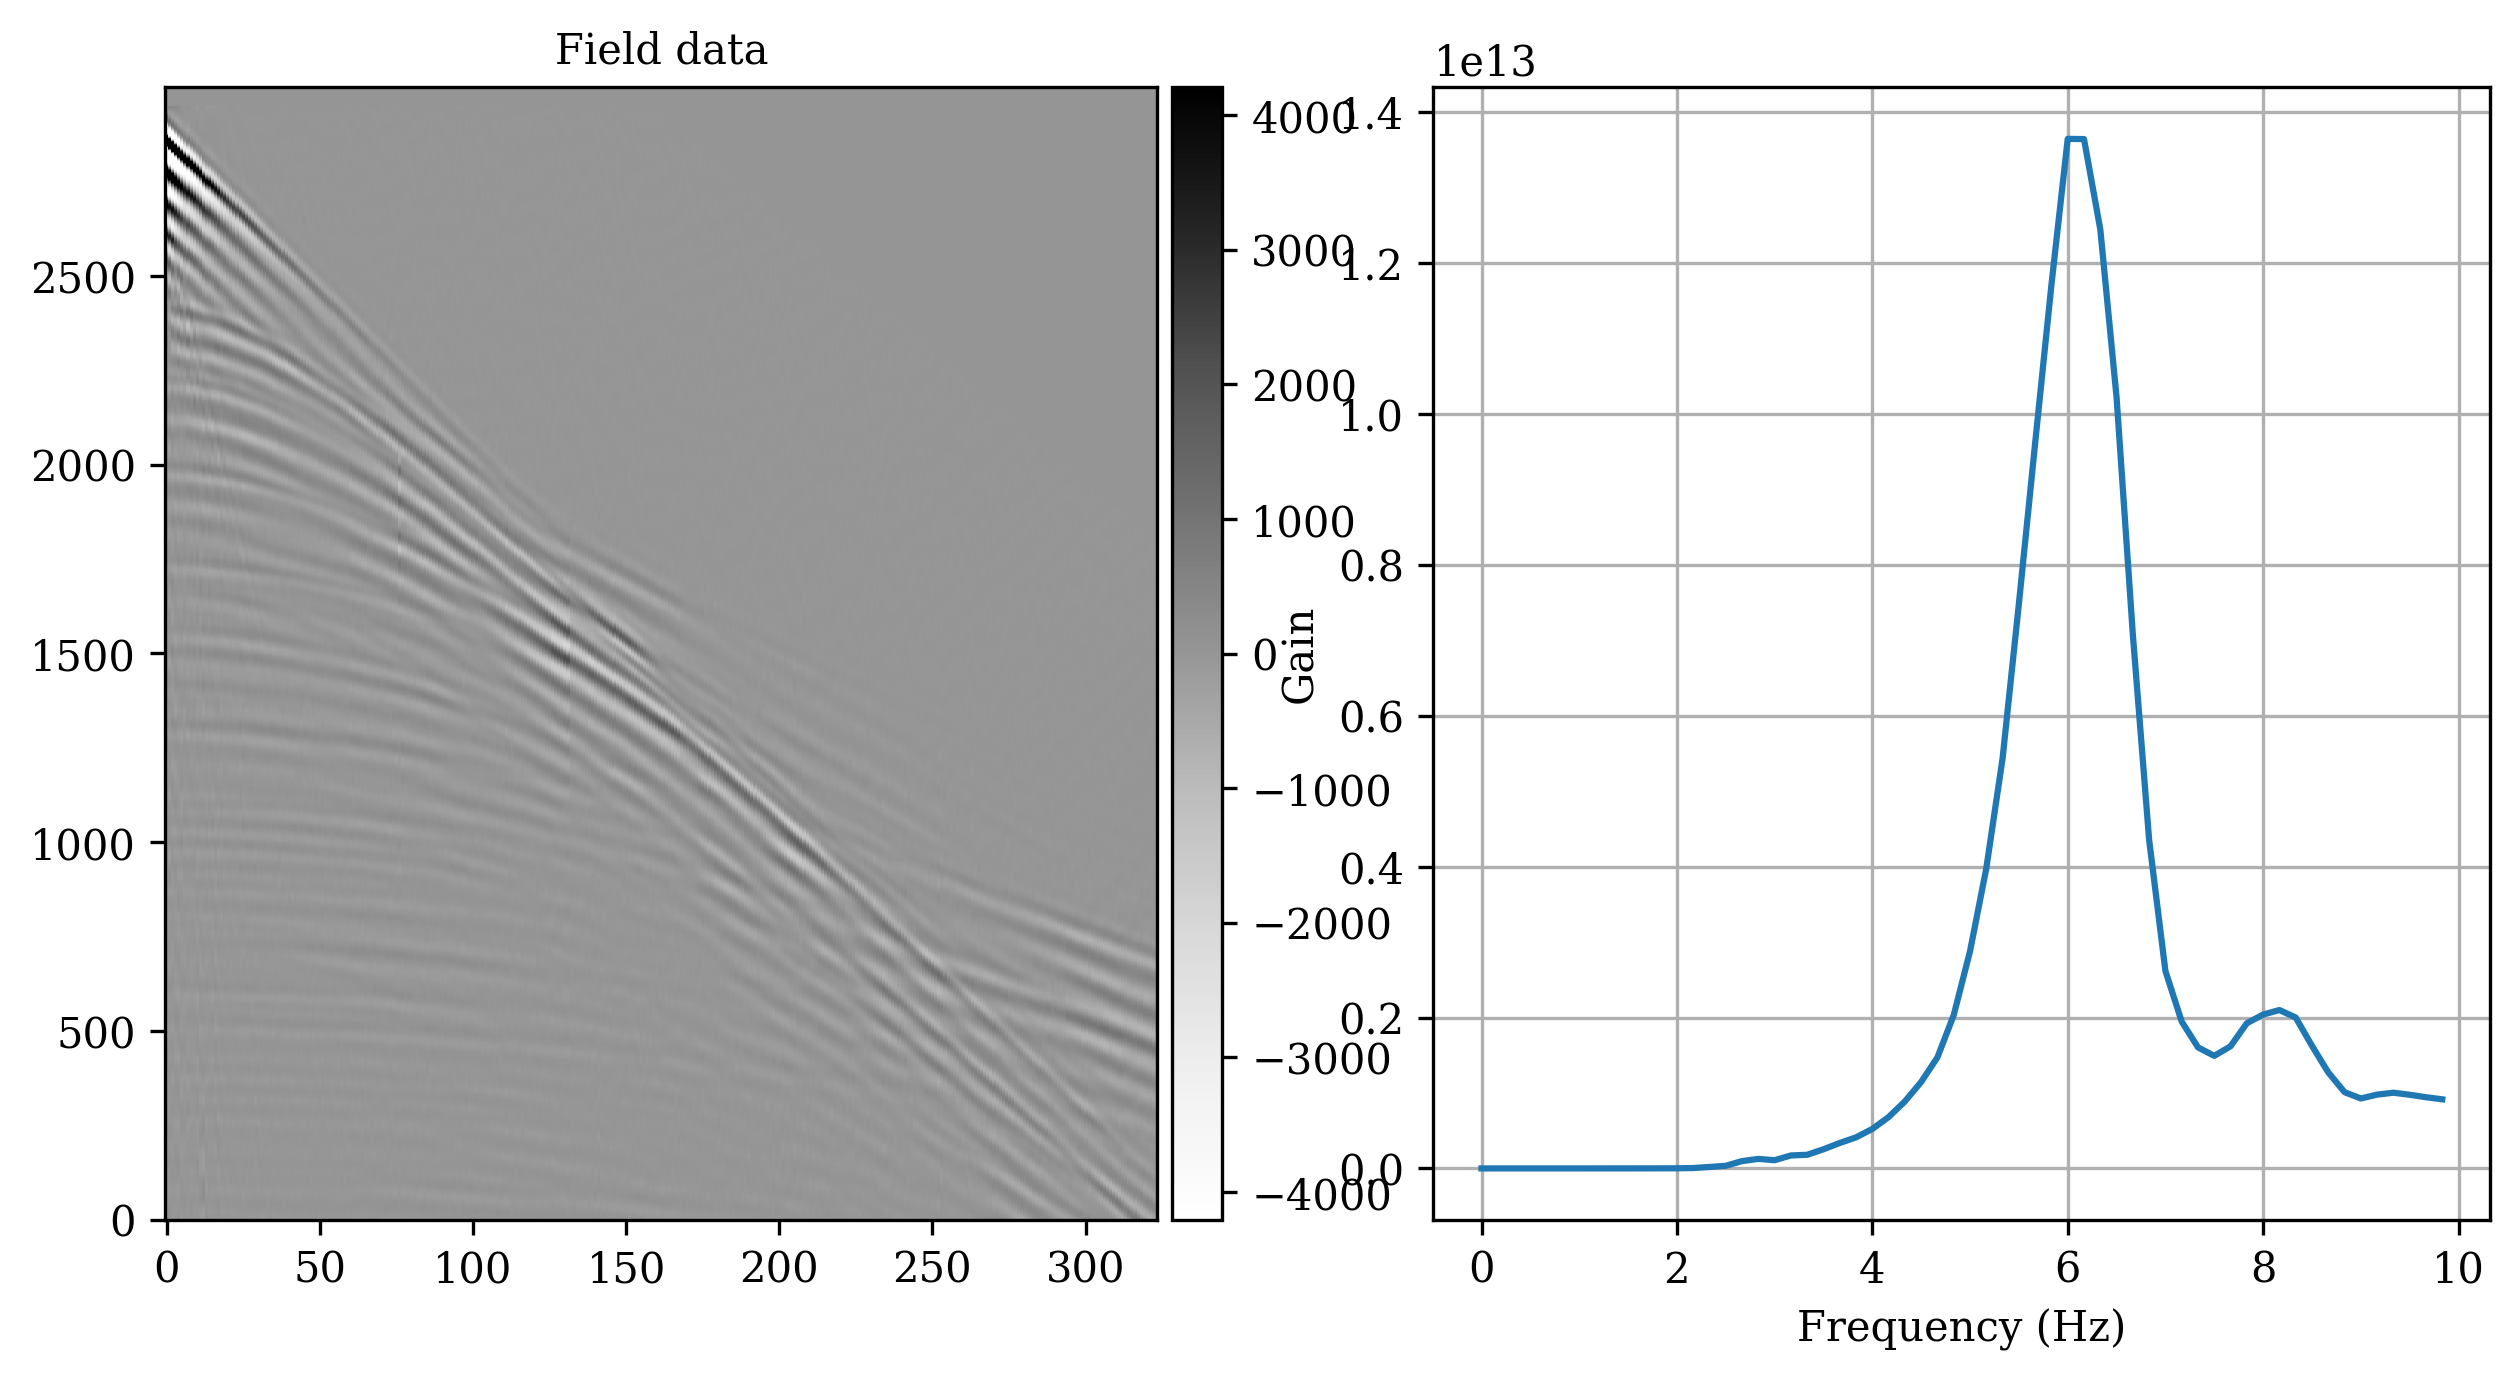

In [35]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape, data_p.min(), data_p.max())
dref = np.mean(data_p, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Save field data to a new folder in /su/

In [36]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [55]:
from glob import glob
root_su_field = os.path.join(d._root_su, 'field/'); 
print(d._root_su)
print(root_su_field)
# copy_su_from_to(d._root_su, root_su_field)


./out_for_pasha/fwi_full_spectrum/fld/su
./out_for_pasha/fwi_full_spectrum/fld/su/field/


In [ ]:
shots,filenames=d.get_shots_from_directory(d._root_su,keys=['_p'],return_filenames=True)
# print(filenames)
# for shot,filename in zip(shots,filenames):
#     print(filename)
#     plot_shot(shot,pclip=0.05,folder_path=d._root_su,file_path=filename.split('/')[-1]+'.png',show=0)

In [39]:
def filter_seismic_data(path,dt=0.002,corner_frequency=5,fmax=10):
    # d=api.Denise('./',verbose=1)
    d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=0)
    shots,filenames=d.get_shots_from_directory(path,return_filenames=True)
    print('low frequency data corner frequency, ',corner_frequency)
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    counter=0
    for shot,filename in zip(shots,filenames):
        ################    processing stage 1
        filtered_shot=bandpass(shot,fhi=6, dt=dt,order=8, btype='low')
        ################    processing stage 2
        filtered_shot2=bandpass(shot,flo=corner_frequency+0.8,dt=dt,order=8,btype='high')
        filtered_shot2_=bandpass(shot,flo=corner_frequency+0.8,fhi=6,dt=dt,order=8,btype='band') #for plotting purposes
        ################    processing stage 3
        filtered_shot3=zero_below_freq(filtered_shot2,corner_frequency+0.1,dt, disable=False,reverse=False)
        filtered_shot3_=zero_below_freq(filtered_shot2_,corner_frequency+0.1,dt, disable=False,reverse=False)
        ################
        plotting_flag=1
        if plotting_flag==1:
            shots_list=[0,22,44,66]
            if counter in shots_list:
                plot_shot(shot,pclip=0.05,folder_path=path,file_path='shot_'+str(counter)+'.png',show=0)
                plot_shot(filtered_shot2,pclip=0.05,folder_path=path,file_path='shot'+str(counter)+'_stage2.png',show=0)
                freqs,ps=plot_spectrum(shot,dt,fmax=fmax,folder_path=path,file_path='spectrum_'+str(counter)+'_original.png')
                freqs,ps=plot_spectrum(filtered_shot2,dt,fmax=fmax,folder_path=path,file_path='spectrum_'+str(counter)+'stage2.png')
        ################    chosen processing    
        with segyio.su.open(filename,"r+",endian='little',ignore_geometry=True) as dst:
            dst.trace=filtered_shot2
        # shot_read,read_filename=d.get_shots_from_datadir(keys=[filename],return_filenames=True); shot_read=shot_read[0]
        counter=counter+1
    return None

print(os.getcwd())
print(d.DT)
su_field_path1 = os.path.join(os.getcwd(),'su_field_high_pass_5_hz/')
su_field_path2 = os.path.join(os.getcwd(),'su_field/')

# api._cmd('rm -r '+su_field_path1)
# copy_su_from_to(d._root_su,su_field_path1)
# filter_seismic_data(su_field_path1,dt=0.002,corner_frequency=5,fmax=10)
# copy_su_from_to(d._root_su,su_field_path2)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
0.002


In [40]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames
fnames = get_fnames_pattern(root_su_field + '*.su.*')

80 files found in ./out_for_pasha/su/field/*.su.*


# Write field data into created .su files

In [41]:
print(data_p.shape, geom.shape)
geom_slice = geom[0, ...]

(80, 324, 3000) (80, 324, 3000)


In [54]:
print(fnames)
for i, f in enumerate(fnames):
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = data_p[i, :, ::d.NDT] / geom_slice[..., ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape, end='\r')

[]


# Copy field data to folder with FWI for CNN and apply high-pass filter above 5 Hz

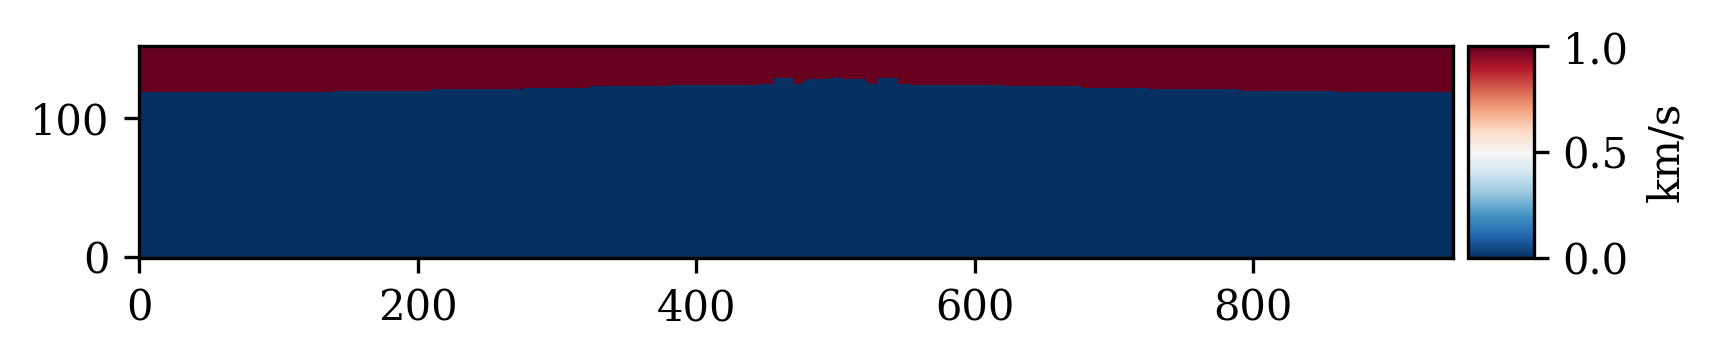

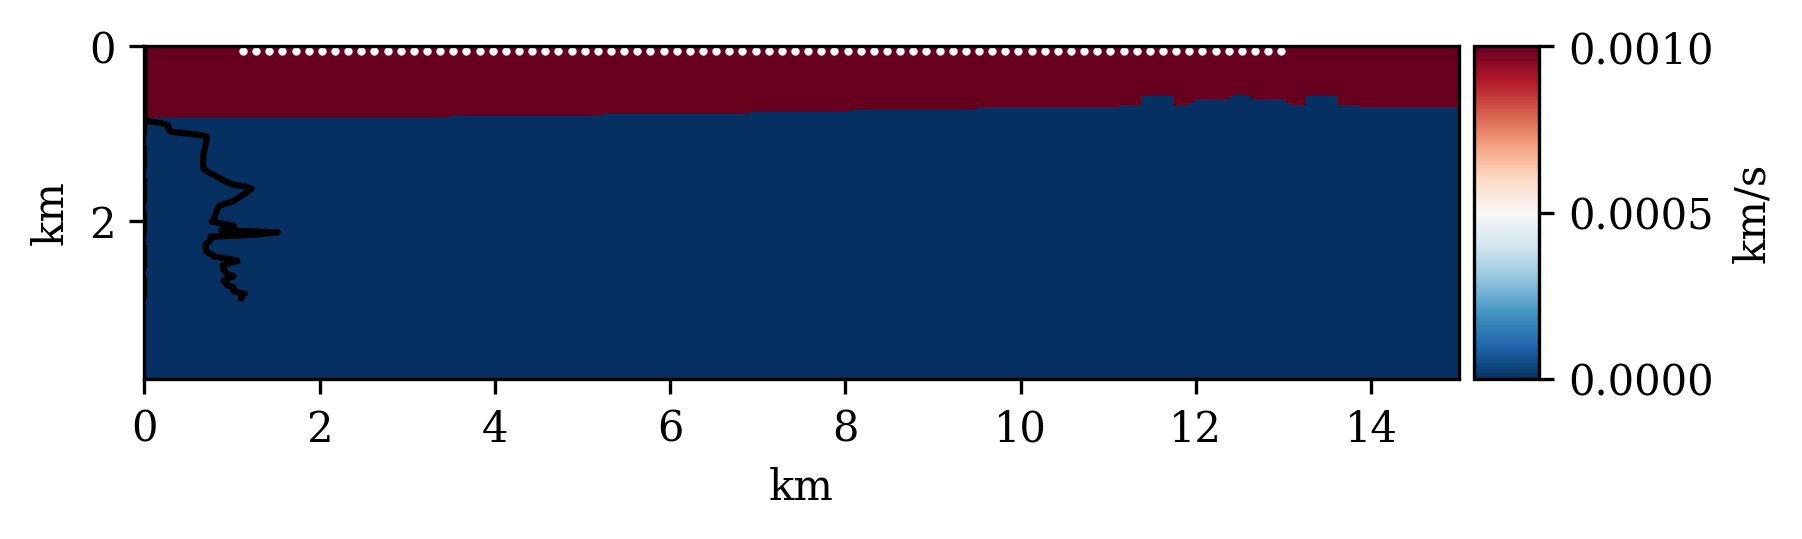

In [43]:
vis.plot_model(wb_taper)
vis.plot_log_model(wb_taper, dx, nx0, nz0, src, log=wlog, log_location=0)

{'vmin': 1.49, 'vmax': 3.2}


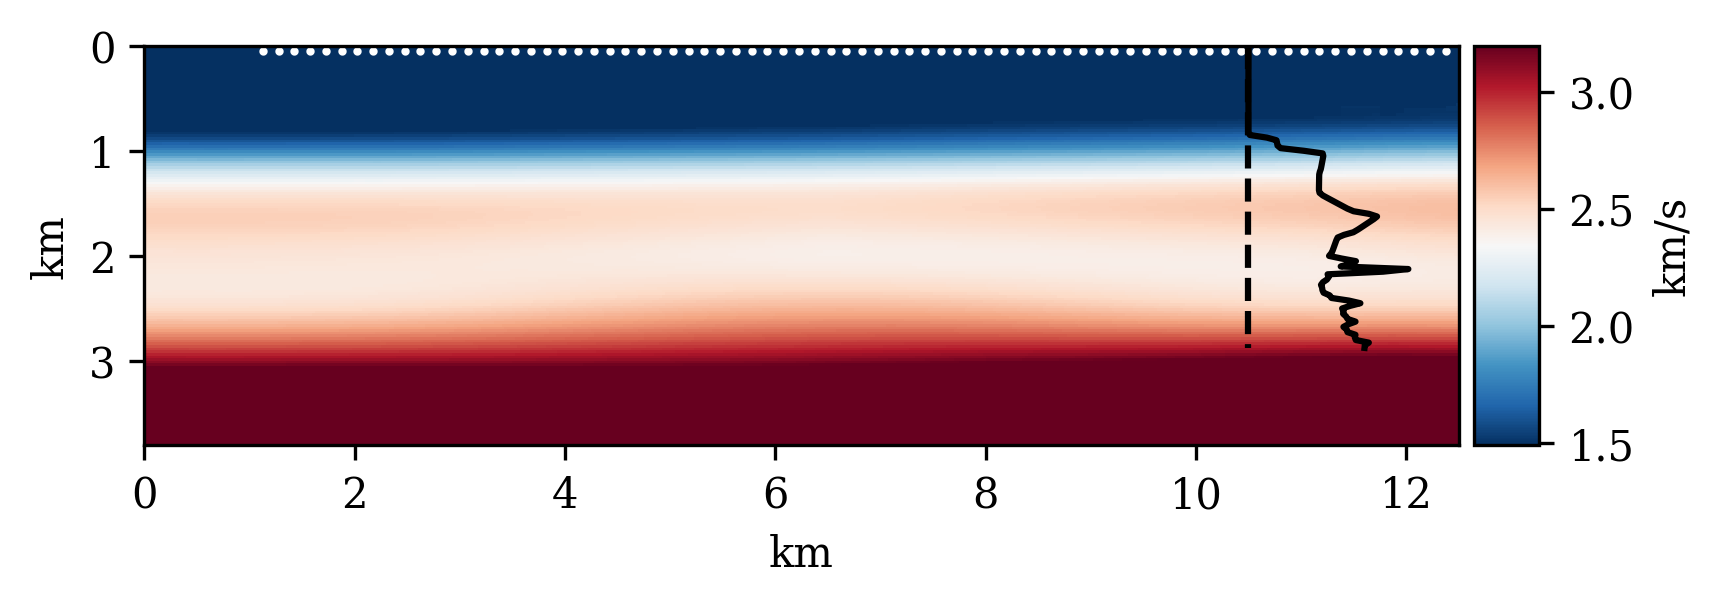

In [44]:
nx0 = 500
# limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': 3200 / 1000}
print(limits_vp)
vis.plot_log_model(model.vp, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)

### Abstraction over initial model

In [45]:
model_init = copy.copy(model)
print(model_init)

vp:	(152, 944), 1490.0000, 3967.7981 m/s

vs:	(152, 944), 0.0000, 2290.8093 m/s

rho:	(152, 944), 1000.0000, 2380.9959 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

116 (152, 944) 152


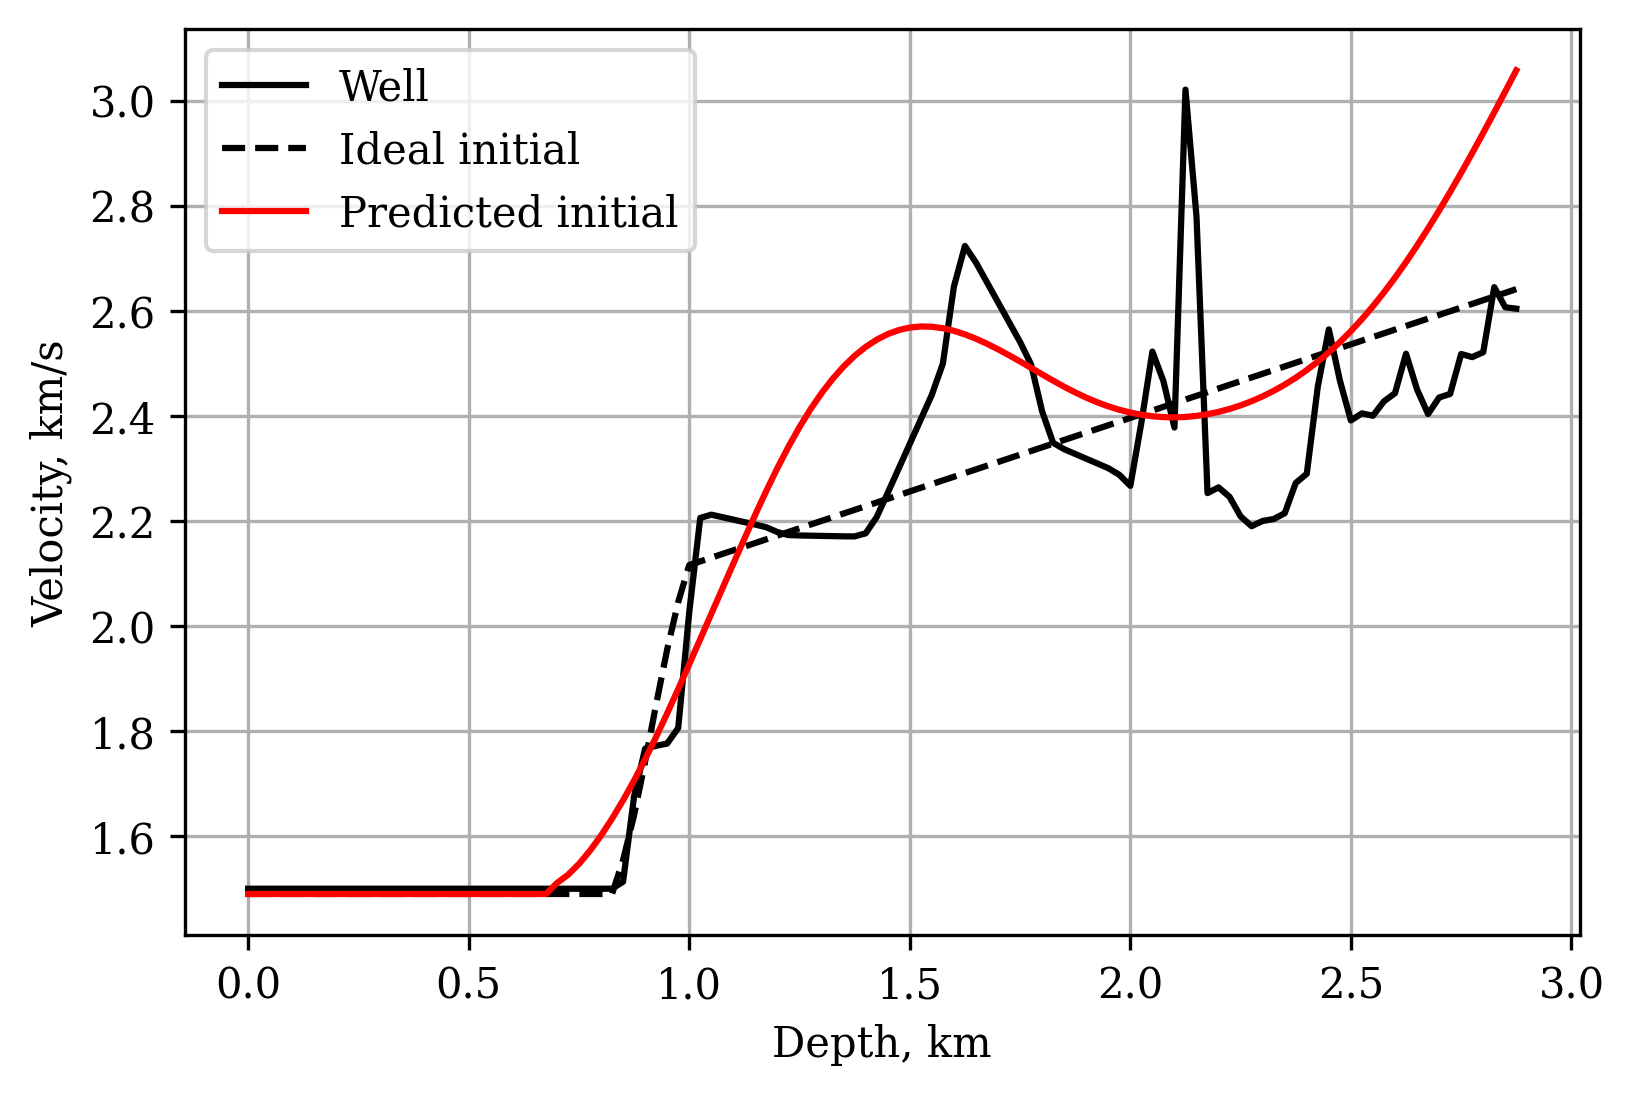

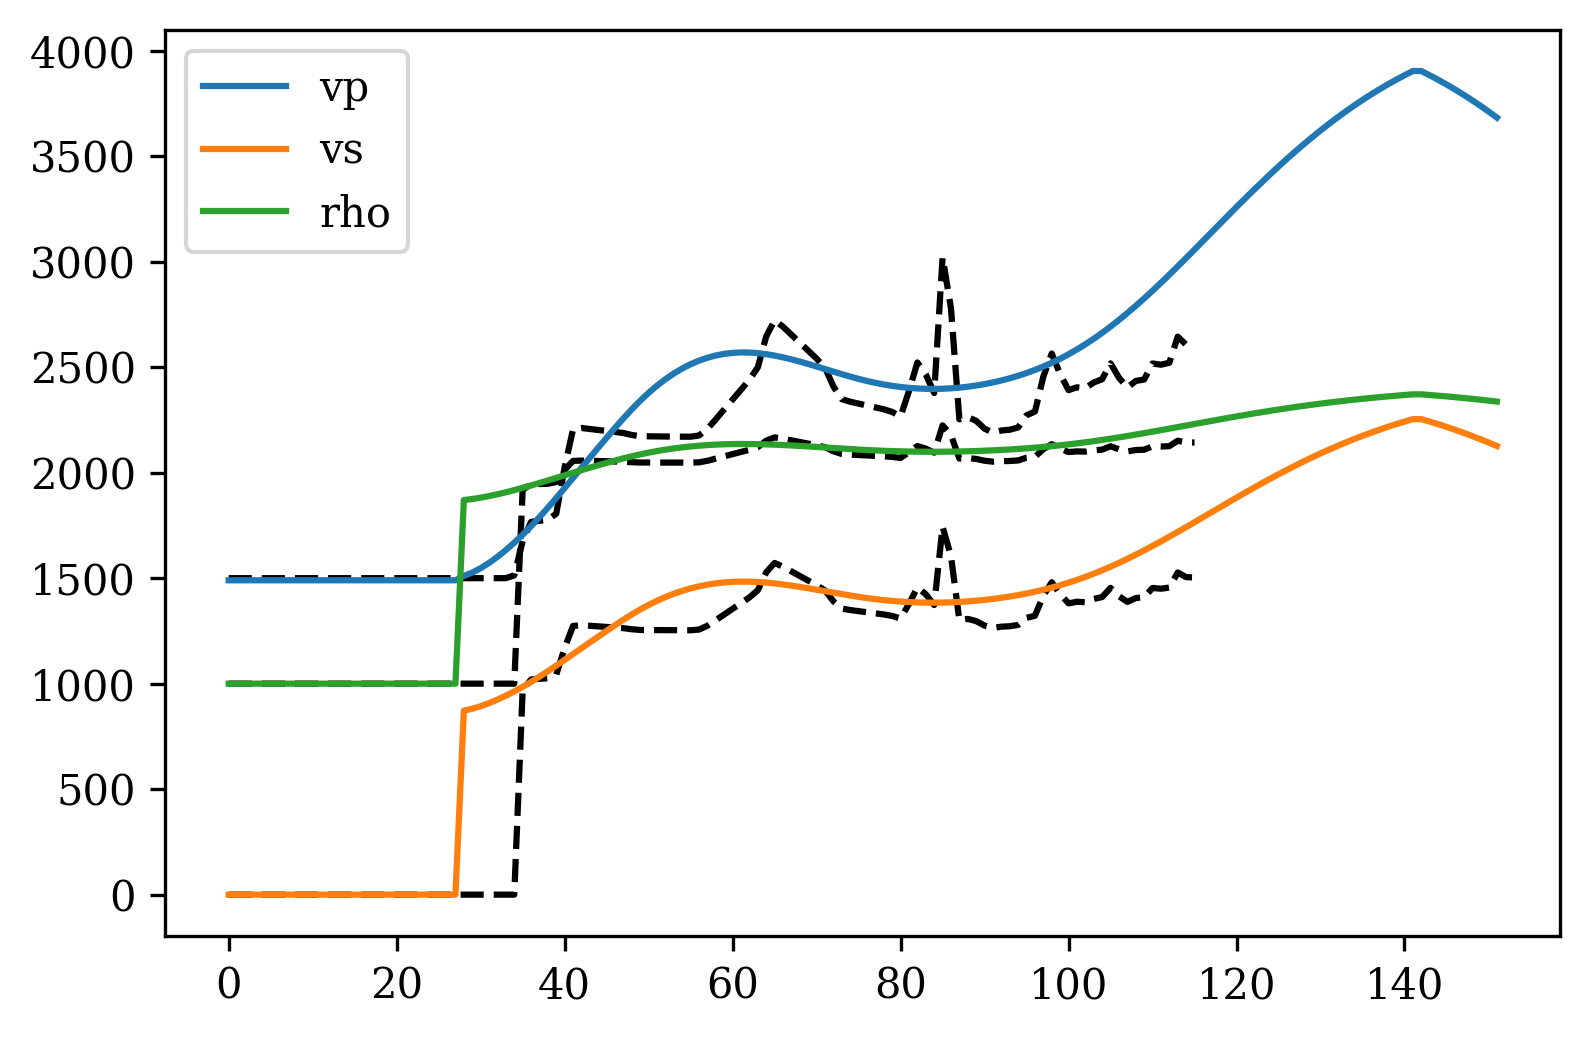

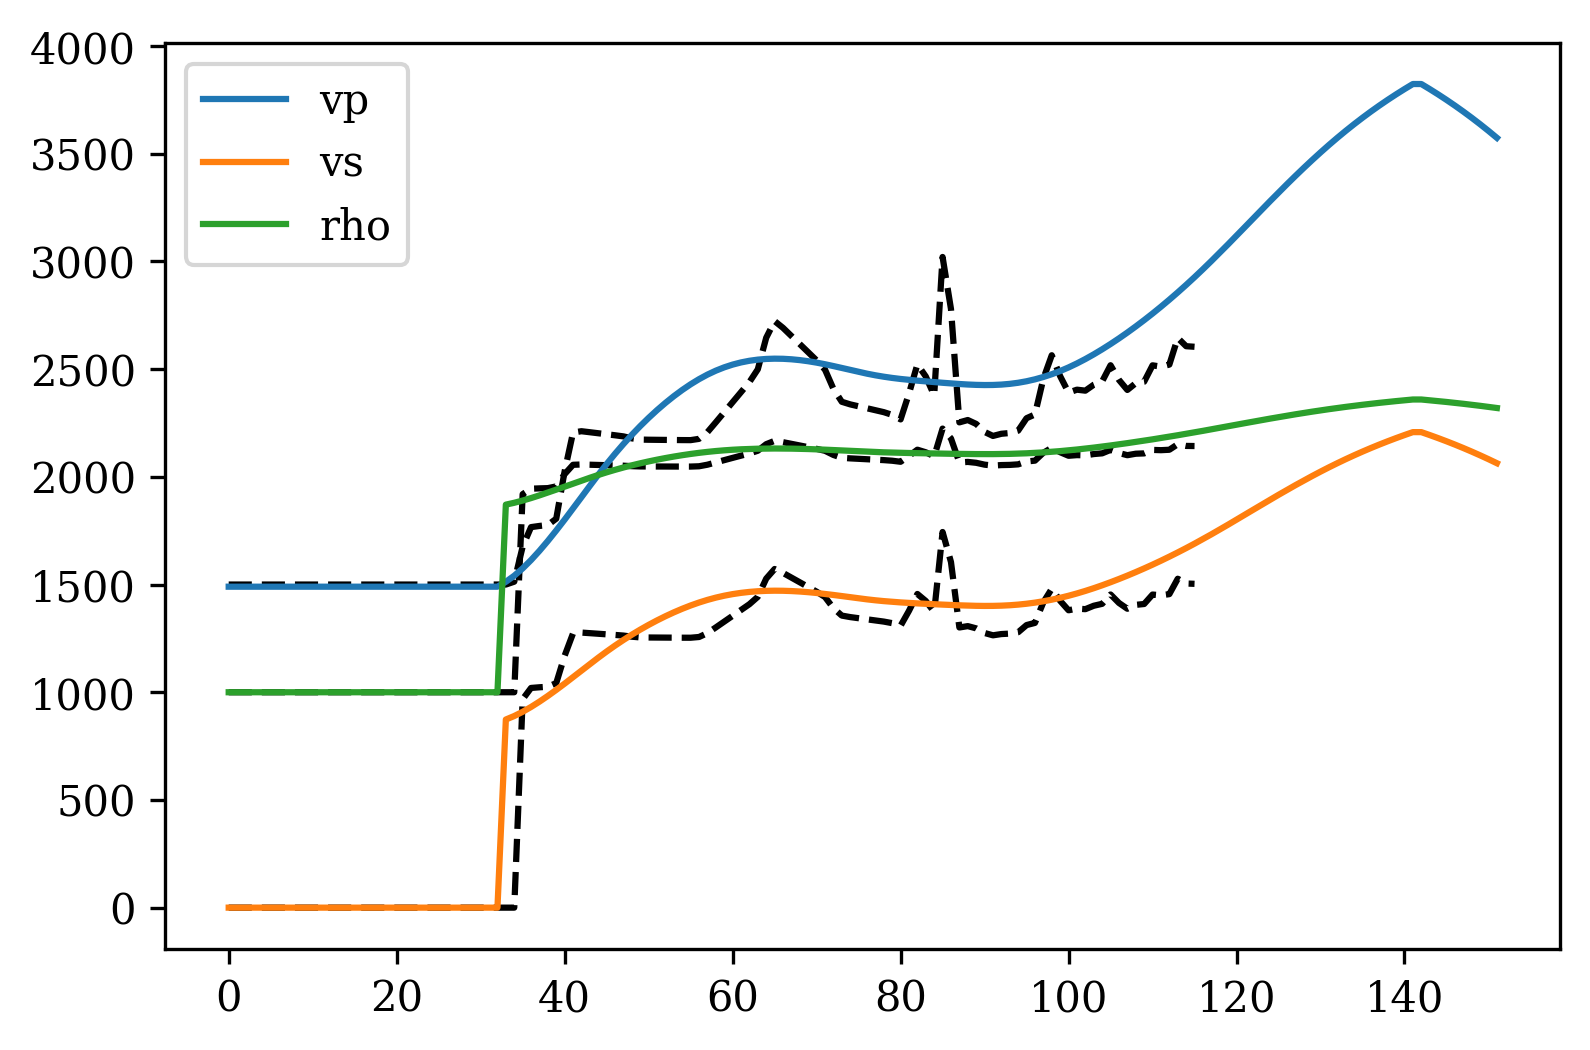

In [46]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(wlog)) * dx / 1000
# ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, wlog[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log[::-1] / 1000, 'k--', label='Ideal initial')

# log_pred = model_init.vp[-len(wlog):, log_idx]

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:,log_idx]))
plot_logs(model_log, model_init, log_idx)
plot_logs(model_log, model_init, 0)

# Run inversion on full-frequency range with proofed to work strategy

In [47]:
denise_shaheen_root='/lustre/project/k1404/pavel/DENISE-Black-Edition'
ITERMAX=1

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
./out_for_pasha/fwi_full_spectrum/fld/
(152, 944) (152, 944)
Save (944, 152) as binary to ./out_for_pasha/fwi_full_spectrum/fld/taper/taper.bin
Save (944, 152) as binary to ./out_for_pasha/fwi_full_spectrum/fld/taper/taper_u.bin
Save (944, 152) as binary to ./out_for_pasha/fwi_full_spectrum/fld/taper/taper_rho.bin
Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 3, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 2, 'WD_DAMP1': 2, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 4, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'IN

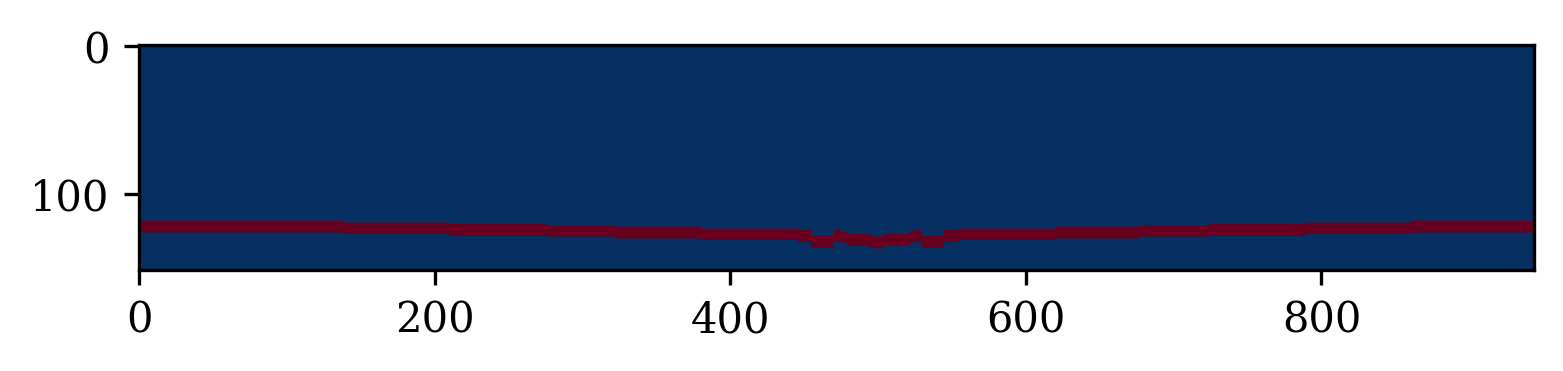

In [48]:
ITERMAX=1;
import F_fwi
# %%capture
results_path='./out_for_pasha/fwi_full_spectrum'
os.system(f"rm -r {results_path}")

d = api.Denise(denise_root, verbose=0)
d.save_folder=os.path.join(results_path,'fld','');      print(d.save_folder)
d.set_paths(makedirs=True)

d.PHYSICS=1
d.INV_MOD_OUT=1
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)
d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10
d.QUELLTYPB = 4
d.QUELLART = 3  
d.WRITE_STF = 0
d.SEISMO = 2

d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30
d.ITERMAX=ITERMAX
# import loaders as ld
d.VPLOWERLIM = np.min(model_init.vp)
d.VSLOWERLIM = np.min(model_init.vs)
d.RHOLOWERLIM = np.min(model_init.rho)
# d.VPUPPERLIM = 3000.
# d.VSUPPERLIM = 2500.
# d.RHOUPPERLIM = 2500.
d.VPUPPERLIM =np.max(model_init.vp)+1000
d.VSUPPERLIM = np.max(model_init.vs)+500
d.RHOUPPERLIM = np.max(model_init.rho)+500
d.SWS_TAPER_FILE = 1
taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 8
taper[shift:, :] = wb_taper[:-shift,:] # water mask
plt.imshow(wb_taper-taper)

if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
###################################### full_fwi_strategy  #########################################################
par_stages_fwi={'inv_vs_iter': 0,
                 'inv_rho_iter': 0,
                 'normalize': 2,
                 'order': 6,
                }
d.fwi_stages = []
freqs_high = [3, 4, 5, 6, 7]
grad_smoothing = [2, 1.5, 0.5, 0.25, 0.125]
lnorms = [2, 2, 2, 2, 2, 2]
spatfilters = [4, 4, 0, 0, 0, 0]
for i, freq in enumerate(freqs_high):
    d.add_fwi_stage(fc_high=freq, 
                    wd_damp=grad_smoothing[i],
                    wd_damp1=grad_smoothing[i],
                    lnorm=lnorms[i],
                    spatfilter=spatfilters[i],
                    **par_stages_fwi)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')
d.DATA_DIR =os.path.join(d.save_folder,'su','seis')
print('d.DATA_DIR=',d.DATA_DIR)
d.WRITE_STF = 0
# d.NPROCX = 4;   d.NPROCY = 1
d.NPROCX = 4;   d.NPROCY = 2
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}
if d.DT is None:
    d.DT = 0.002
d.filename=os.path.join(d.save_folder,'seis_inversion.inp');    print(d.filename)
d.MFILE=os.path.join(d.save_folder,'start/model')
d.fwi(model_init, src, rec, **par_fwi_runtime)
d.MFILE=os.path.join(d.save_folder,'start/model_init')
d.fwi(model_init, src, rec, **par_fwi_runtime)
copy_su_from_to('./out_for_pasha/su/field',os.path.join(d.save_folder,'su'))
# denise_folder_process('crop_zero_freqs',results_path,denise_root=denise_root)
# denise_folder_process('plot',results_path,denise_root=denise_root)

post_processing_script_name = os.path.join(results_path,'post_processing_script.py')
print(post_processing_script_name)
imports = 'import sys,os\n'
imports = imports+f"sys.path.append(os.getcwd())\n"
imports = imports+f"sys.path.append('/lustre/project/k1404/pavel/DENISE-Black-Edition')\n"
imports = imports+'from F_utils import *\n'
imports = imports+'from F_plotting import *\n'
imports = imports+'from F_fwi import *\n'
imports = imports+'import fnmatch\n'
imports = imports+'from glob import glob\n'
imports = imports+'import numpy as np\n'
imports = imports+'import pyapi_denise_pavel as api\n'
post_processing = imports
post_processing = post_processing+f"denise_folder_process('plot','{results_path}',denise_root='{denise_shaheen_root}')\n"
# post_processing = post_processing+f"denise_folder_process('optimizing_space_','{results_path}',denise_root='{denise_shaheen_root}')\n"
# post_processing = post_processing+f"denise_folder_process('plot','{results_path}',denise_root='{denise_shaheen_root}')\n"
f = open(post_processing_script_name, 'w')
f.write(post_processing)
f.close()
create_sbatch_file_for_fwi_folder('fwi_full_spectrum.sh',results_path)

In [49]:
print('d.DATA_DIR=',d.DATA_DIR)

d.DATA_DIR= ./out_for_pasha/fwi_full_spectrum/fld/su/seis


### Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

In [50]:
# d.set_model(model_init)
# print(d.save_folder)
d.save_folder = os.path.join(root_fwi,'fwi_full_spectrum','fld')
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)

Parse files from ./out_for_pasha/fwi_full_spectrum/fld/model which contain ['vp', 'stage']
No files found! Exception raised.


### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [51]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

Parse files from ./out_for_pasha/fwi_full_spectrum/fld/model which contain ['vp_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha/fwi_full_spectrum/fld/model which contain ['vs_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha/fwi_full_spectrum/fld/model which contain ['rho_stage']
No files found! Exception raised.


### Gradients

In [52]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [53]:
def get_model_last():
    all_fnames = []
    # vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    vps, fnames = d.get_fwi_models(['vp'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho'], return_filenames=True)
    all_fnames += fnames
    print(all_fnames)
    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)
    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    # print(vps)
    return model_last
    # return None
model_last=get_model_last()

[]


UnboundLocalError: local variable 'model_last' referenced before assignment

In [ ]:
vis.plot_model(model_last.vp / 1000, **limits_vp)

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
print(d.save_folder)
if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

In [ ]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [ ]:
par_forward = {'run_command': 'mpirun -np 30', 'disable': False}
print(par_forward)

In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.verbose=1
d.forward(model_last, src, rec, **par_forward)

In [ ]:
print(src.x[19], src.x[62])

In [ ]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

mpl.rcParams['figure.dpi']= 300
# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
for ishot in [19, 62]:
    print(ishot)
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)